In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-06 19:42:16--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  1.26MB/s    in 1.1s    

2023-10-06 19:42:18 (1.26 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [ ]:
Make,
Model,
Year,
Engine HP,
Engine Cylinders,
Transmission Type,
Vehicle Style,
highway MPG,
city mpg
MSRP

In [95]:
df = pd.read_csv('data.csv')

# Keep only the columns above
df = df[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg', 'MSRP']]

# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Fill the missing values with 0
df[list(df.columns)] = df[list(df.columns)].fillna(0)

# Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
price_mean = np.mean(df['msrp'].tolist())
df['above_average'] = [1 if x >= price_mean else 0 for x in df['msrp'].tolist()]

In [138]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
# Use train_test_split function for that with random_state=1

# test is 20%
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# full train = 80%, final train is 60% and validation is 20%
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
#del df_full_train['above_average']
del df_val['above_average']
del df_test['above_average']

del df_train['msrp']
del df_full_train['msrp']
del df_val['msrp']
del df_test['msrp']



In [111]:
df_train[0:3]

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19


In [112]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/alla/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [113]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

price_decision = (y_pred >= 0.5)

In [114]:
price_decision

array([ True, False,  True, ..., False,  True, False])

# Question 1: ROC AUC feature importance: engine_hp

In [115]:
# For each numerical variable, use it as score and compute AUC with the above_average variable
# Use the training dataset for that

# If your AUC is < 0.5, invert this variable by putting "-" in front
# AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

# Which numerical variable (among the following 4) has the highest AUC?

In [116]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [117]:
df_train_subset

array([[27],
       [18],
       [19],
       ...,
       [32],
       [16],
       [14]])

In [118]:
for feature in numerical:
    df_train_subset = df_train[feature].to_numpy().reshape(-1, 1)

    if feature == 'year':
        df_train_subset = -df_train[feature].to_numpy().reshape(-1, 1)
        
    model = LogisticRegression()
    model.fit(df_train_subset, y_train)

    df_val_subset = df_val[feature].to_numpy().reshape(-1, 1)
    y_pred = model.predict_proba(df_val_subset)[:, 1]
    
    print (feature, 'ROC AUC:', roc_auc_score(y_val, y_pred))

year ROC AUC: 0.6908056131861057
engine_hp ROC AUC: 0.9153308465235073
engine_cylinders ROC AUC: 0.7690689320336834
highway_mpg ROC AUC: 0.6286428845579014
city_mpg ROC AUC: 0.6699949414821458



# Question 2: Training the model:0.979





In [119]:
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# What's the AUC of this model on the validation dataset? (round to 3 digits)

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [120]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

print (np.round(roc_auc_score(y_val, y_pred)))

1.0


In [121]:
df_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
3,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
4,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17
...,...,...,...,...,...,...,...,...,...
7143,Subaru,Impreza,2015,148.0,4.0,MANUAL,4dr Hatchback,33,24
7144,Infiniti,QX50,2016,325.0,6.0,AUTOMATIC,4dr SUV,24,17
7145,Honda,Fit,2017,130.0,4.0,AUTOMATIC,4dr Hatchback,37,32
7146,Audi,200,1991,162.0,5.0,AUTOMATIC,Sedan,20,16


# Question 3: Precision and Recall: 0.48

In [122]:
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

# For each threshold, compute precision and recall

# Plot them

# At which threshold precision and recall curves intersect?

In [123]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [124]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores[0:2]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,654,1729,0,0,1.000000,1.000000,0.274444,1.000000
1,0.01,652,770,2,959,0.996942,0.445344,0.458509,0.996942


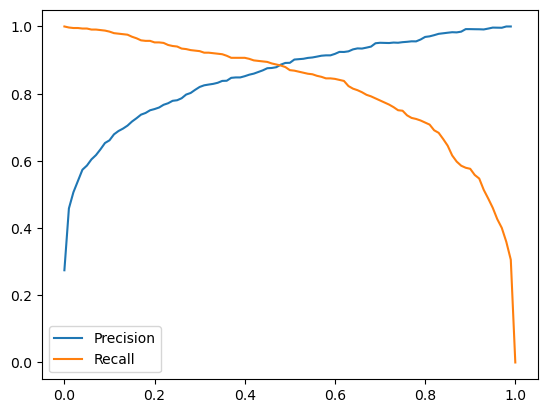

In [125]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [126]:
df_scores[df_scores['threshold'] == 0.48]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
48,0.48,578,74,76,1655,0.883792,0.042799,0.886503,0.883792


In [127]:
df_scores[df_scores['threshold'] == 0.68]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
68,0.68,518,33,136,1696,0.792049,0.019086,0.940109,0.792049


# Question 4: F1 score,0.52 the closest


In [128]:
df_scores['F1'] = 2* df_scores.precision * df_scores.recall / (df_scores.precision+df_scores.recall)

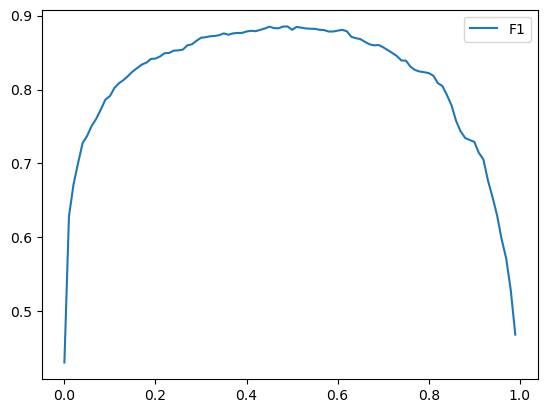

In [129]:
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()

In [130]:
df_scores[df_scores['F1'] == df_scores.F1.max()].threshold	

49    0.49
Name: threshold, dtype: float64

# Question 5: 5-Fold CV, 0.003 the closest

In [131]:
# KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different folds of df_full_train

# Split the data into train and validation

# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# Use AUC to evaluate the model on validation

In [148]:
def train(df_train, y_train, C=1.0):
    del df_train['above_average']
    
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [142]:
dv, model = train(df_train, y_train, C=0.001)

In [143]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [144]:
y_pred = predict(df_val, dv, model)

In [145]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [147]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=10 0.979 +- 0.002


# Question 6: Hyperparemeter Tuning, 10

In [ ]:
#cNow let's use 5-Fold cross-validation to find the best parameter C

# Iterate over the following C values: [0.01, 0.1, 0.5, 10]

# Initialize KFold with the same parameters as previously

# Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [150]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.002
C=10 0.981 +- 0.003
